# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデル・3期間モデルと数値計算の概観

## 2.6 一階条件を使う：求根アルゴリズム
### 2.6.1 非線形方程式のゼロ点を探す

### パラメータの設定はこれまでと同じ

In [1]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度

    # 要素価格
    rent::Float64 #純利子率

    # グリッド
    nw::Int64 #所得グリッドの数
    w_max::Float64 #所得グリッドの最大値
    w_min::Float64 #所得グリッドの最小値
    grid_w::Vector{Float64} #所得グリッド
end

In [2]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

In [6]:
# パラメータを設定
params = Calibration()

Models(0.6354580927313491, 2.0, 1.0975675790817858, 10, 1.0, 0.1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8999999999999999, 1.0])

---

## 経済学でよく使う関数を設定しておく
* 限界効用
$$
    u'(c) = c^{-\gamma}
$$

In [3]:
function mu_CRRA(cons::Float64, γ::Float64)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [5]:
# インストール済みならここはスキップ
#using Pkg
#Pkg.add("Roots")

In [4]:
# Root Finding用のライブラリを読み込む
using Plots
pyplot()
using Roots # ここが新しいところ：前回はOptimだった

---

## ゼロ点を探す関数を作成
* **残差関数（residual function）**
* テキストの(2.8)式

In [7]:
"""
2期間モデルの1階条件の残差を求める

### インプット
`a::Float64`: 貯蓄水準
`w_val::Float64`: 所得水準
`m::Models`: パラメータを含む構造体

### アウトプット
残差
"""
function resid_two_period(a::Float64, w_val::Float64, params::Models)

    # オイラー方程式の左辺：若年期の限界効用
    if w_val - a > 0.0
        mu1 = mu_CRRA(w_val - a, params.γ)
    else
        mu1 = 10000.0
    end

    # 老年期の限界効用
    mu2 = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu2/mu1) - 1.0

end 

resid_two_period

---

## 実際にゼロ点を探す

In [8]:
# 空の変数を用意
a_nl = zeros(params.nw)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [9]:
# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for i = 1:params.nw

    w_val = params.grid_w[i]

    # 1変数のfunctionにする
    resid_two_period!(a) = resid_two_period(a, w_val, params)

    # 0.01はゼロ点を探す際の初期値
    a_nl[i] = find_zero(resid_two_period!, 0.01)

end

print(a_nl)

[0.035500887771154545, 0.0710017755423091, 0.10650266331346364, 0.14200355108461818, 0.17750443885577274, 0.21300532662692728, 0.24850621439808182, 0.2840071021692364, 0.31950798994039087, 0.35500887771154543]

### ⬆のプロセスを一つの関数にまとめる

In [10]:
"""
ゼロ点探索によって2期間モデルを解く

# インプット
`m::Models`:パラメータを含む構造体

# アウトプット
`a_nl::Vector`:政策関数
"""
function Root_find(params::Models)
    a_nl = zeros(params.nw)
    for i = 1:params.nw
        w_val = params.grid_w[i]
        resid_two_period!(a) = resid_two_period(a, w_val, params)
        a_nl[i] = find_zero(resid_two_period!, 0.01)
    end
    return a_nl
end

Root_find

In [11]:
# 関数の実行
@time a_nl = Root_find(params) # 実行時間の計測

  0.000048 seconds (11 allocations: 1.703 KiB)


10-element Vector{Float64}:
 0.035500887771154545
 0.0710017755423091
 0.10650266331346364
 0.14200355108461818
 0.17750443885577274
 0.21300532662692728
 0.24850621439808182
 0.2840071021692364
 0.31950798994039087
 0.35500887771154543

---

## 結果を出力

In [12]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w;

---

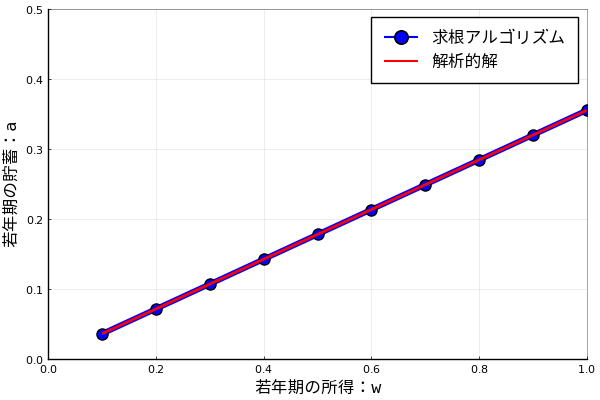

In [13]:
# 図2.2とほぼ同じ
plt = plot(params.grid_w, a_nl,
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("求根アルゴリズム"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="解析的解")
#savefig("Fig2_pol_root_finding.pdf")

---

### 残差をプロットする：図2.3

In [14]:
"""
本文中の残差についての図を書くための関数
"""
function resid_ex(params::Models)

    na = 40
    a_max = 1.0
    a_min = 0.025
    grid_a = collect(LinRange(a_min, a_max, na))

    resid = zeros(na, 3)
    grid_zero = zeros(na)

    wlist = [0.5, 0.8, 1.0]
    for i = 1:3
        w_val = wlist[i]
        resid_two_period!(a) = resid_two_period(a, w_val, params)
        for j in 1:na
            resid[j, i] = resid_two_period!(grid_a[j])
        end
    end
    return resid, grid_zero
end

resid_ex

In [15]:
resid, grid_zero = resid_ex(params)

([108.36494907898863 290.1349475482218 459.7869461195062; 23.538949793346486 67.16374942596245 108.36494907898863; … ; -0.9999681314927076 -0.9999681314927076 -0.9998008218294223; -0.9999697050002552 -0.9999697050002552 -0.9999697050002552], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [16]:
na = 40
a_max = 1.0
a_min = 0.025
grid_a = collect(LinRange(a_min, a_max, na));

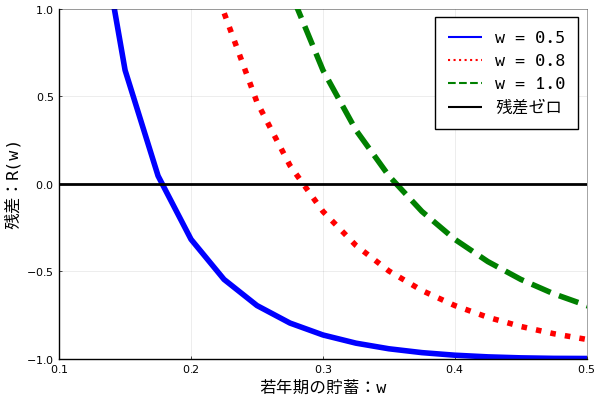

In [17]:
plt = plot(grid_a, resid[:, 1],
    color = :blue,
    linestyle = :solid,
    legend = :topright,
    xlims = (0.1, 0.5),
    ylims = (-1.0, 1.0),
    label = ("w = 0.5"),
    xlabel = ("若年期の貯蓄：w"),
    ylabel = ("残差：R(w)"),
    linewidth = 4,
#    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(grid_a, resid[:, 2], linestyle = :dot, linewidth = 4, color = :red, label="w = 0.8")
plot!(grid_a, resid[:, 3], linestyle = :dash, linewidth = 4, color = :green, label="w = 1.0")
plot!(grid_a, grid_zero, linewidth = 2, color = :black, label="残差ゼロ")
#savefig("Fig2_residual.pdf")

---

## エクササイズ
* 最適化を用いたアルゴリズム(quantmacro_chapter2_2.ipynbを参照)から導出した政策関数の精度を確認してみよう。